In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
from torch.utils.data import DataLoader
from src.dataset import ESC50Dataset
from src.model import AudioCNN

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset (only Fold 1 for validation)
val_dataset = ESC50Dataset(
    csv_path='../data/ESC-50-master/meta/esc50.csv',
    audio_dir='../data/ESC-50-master/audio',
    folds=[1]
)

val_loader = DataLoader(val_dataset, batch_size=16)

# Load trained model
model = AudioCNN(num_classes=50)
model.load_state_dict(torch.load('../models/audio_cnn.pth'))
model.to(device)
model.eval()


AudioCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=27648, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=50, bias=True)
  )
)

Now, it is time to get predicions and labels.

In [5]:
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


Time to plot the confusion matrix...

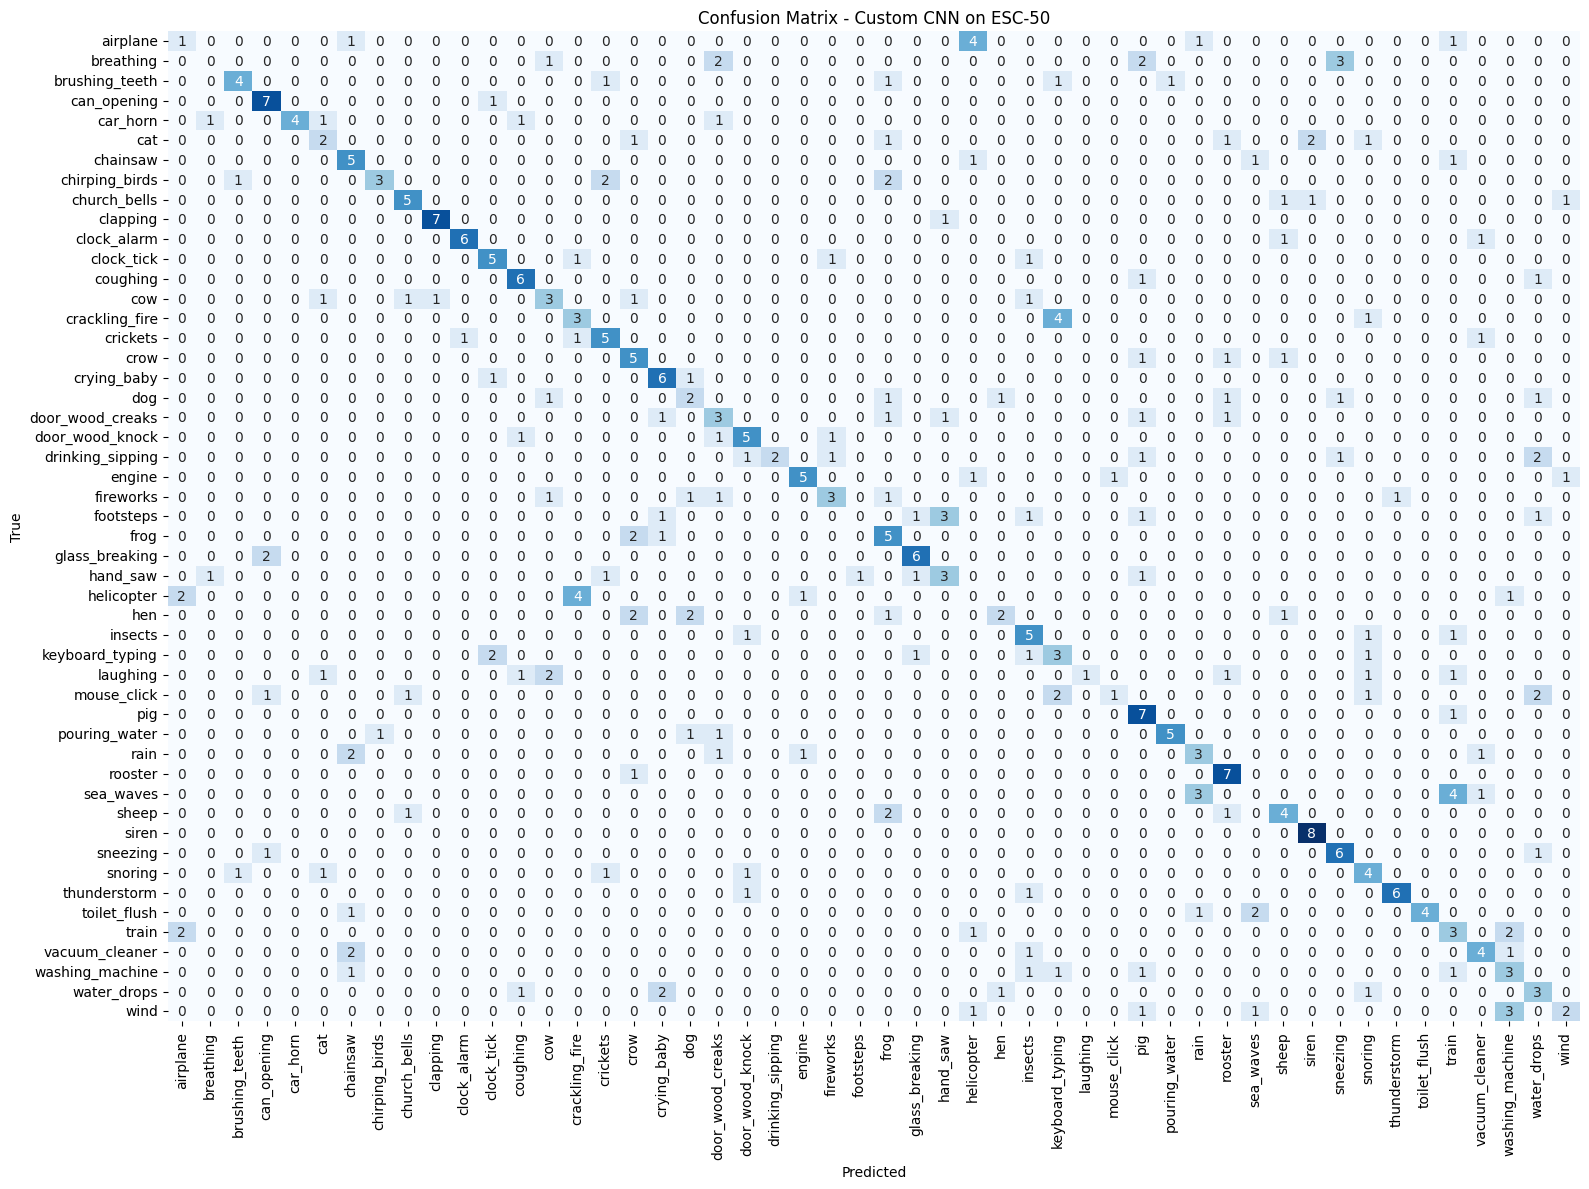

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Map label indices back to class names
label_names = sorted(list(val_dataset.label_to_idx.keys()))

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(16, 12))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, 
            cmap="Blues", fmt="d", annot=True, cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom CNN on ESC-50")
plt.tight_layout()
plt.show()


## 📊 Confusion Matrix Analysis – Custom CNN on ESC-50

After training my custom CNN for 20 epochs, I evaluated the model using a confusion matrix to visualize how well it distinguishes between the 50 sound classes.

### ✅ What Went Well

- There is a strong diagonal trend in the matrix, which indicates that the model is correctly classifying many samples.
- Some classes like `siren`, `sea_waves`, `clock_tick`, `pouring_water`, and `mouse_click` are being predicted with high accuracy — in some cases 7 or 8 out of 8 correctly.
- This shows that the model is learning meaningful features from mel-spectrograms, especially for distinct or high-energy sound patterns.

### 🔍 Where the Model Struggles

While the model performs well overall, I noticed confusion between certain **acoustically similar classes**, which makes sense considering the nature of environmental sounds:

- **`airplane` vs. `helicopter`**: Both are continuous, low-frequency, mechanical sounds. The model confused these often, which makes sense since their spectrograms likely look very similar.
- **`wind` vs. `washing_machine`**: These sounds share ambient, low-varying frequency profiles. The model seemed to mistake subtle textures and classify them interchangeably.
- **`breathing` vs. `sneezing`**: These are both human vocalizations with overlapping frequency bursts, especially in lower energy samples — making them hard to distinguish in short audio clips.

These types of misclassifications are expected in environmental audio tasks, especially given the limited number of training samples per class (only 40).

### 💡 Takeaways

- My model shows clear learning progress and is capable of generalizing to many sound categories.
- However, for sounds that are acoustically similar, the model struggles to separate them — this sets a good baseline for comparison when I move on to transfer learning.
- I plan to use this analysis to improve the model by experimenting with Transfer learning with pretrained CNNs (e.g., ResNet)

